In [ ]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import math
import shutil
import tqdm
import skimage.io
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize


import tensorflow as tf
import keras
import glob
from keras.layers import Dense, Flatten
from keras.models import Sequential
from keras.preprocessing import image

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
!unzip /content/drive/MyDrive/C-NMC_Leukemia.zip

In [ ]:
ROOT_DIR = '/content/C-NMC_Leukemia/training_data/C-NMC_train_phase_data'

In [ ]:
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('2.all', 7272), ('1.hem', 3389)])

In [ ]:
def datafolder(p, split):
    if not os.path.exists("./"+p):
      os.mkdir("./"+p)

      for dir in os.listdir(ROOT_DIR):
        os.makedirs("./"+p+"/"+dir)

        for img in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR, dir)) , size = (math.floor(split*number_of_images[dir])-5), replace=False ):

          O = os.path.join(ROOT_DIR, dir, img)
          D = os.path.join("./"+p, dir)
          shutil.copy(O,D)
          os.remove(O)
    else:
      print(f"{p}Train Folder exist")

In [ ]:
datafolder("train", 0.60)

In [ ]:
datafolder("val", 0.20)

In [ ]:
datafolder("test", 0.20)

In [ ]:
#data_augmentation
train_datagen = image.ImageDataGenerator(
    rescale = 1/255, horizontal_flip = True, vertical_flip = True, zoom_range = 0.2, shear_range = 0.2
)

train_data = train_datagen.flow_from_directory(directory=("/content/train"), target_size= (224,224), batch_size= 32, class_mode = 'binary')

Found 6386 images belonging to 2 classes.


In [ ]:

val_datagen = image.ImageDataGenerator(
    rescale = 1/255
)

val_data = val_datagen.flow_from_directory(directory=("/content/val"), target_size= (224,224), batch_size= 32, class_mode = 'binary')

Found 2121 images belonging to 2 classes.


In [ ]:

test_datagen = image.ImageDataGenerator(
    rescale = 1/255
)

test_data = test_datagen.flow_from_directory(directory=("/content/test"), target_size= (224,224), batch_size= 32, class_mode = 'binary')

Found 2121 images belonging to 2 classes.


In [ ]:
#from tensorflow.keras.applications import ResNet101
#from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, GlobalMaxPool2D

In [ ]:
#densenet = ResNet101(
#    weights="imagenet",
#    include_top=False,
#    input_shape=(224,224,3)
#)

In [ ]:
#model = tf.keras.models.Sequential([densenet,
 #                                       GlobalMaxPool2D(),
  #                                      Dense(512, activation='relu'),
   #                                     
    #                                    Dense(1, activation='sigmoid')
     #                                 ])

In [ ]:
model = Sequential()

pretrained_model = tf.keras.applications.InceptionV3(include_top=False,
                                                        input_shape=(224,224,3),
                                                        pooling='average', classes=2,
                                                        weights='imagenet')

for layer in pretrained_model.layers:
  layer.trainable=False

219070464/219055592 [==============================] - 2s 0us/step


In [ ]:
model.add(pretrained_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics='accuracy')

In [ ]:
# Defining callbacks

filepath = './bestmodel.h5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 6)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

In [ ]:
his = model.fit(train_data, steps_per_epoch=16, epochs=15, validation_steps= 2,
                    validation_data = val_data,
                    callbacks = callback_list
                    )

Epoch 1/15
16/16 [==============================] - ETA: 0s - loss: 13.7321 - accuracy: 0.5703
Epoch 00001: val_accuracy improved from -inf to 0.67188, saving model to ./bestmodel.h5
16/16 [==============================] - 30s 1s/step - loss: 13.7321 - accuracy: 0.5703 - val_loss: 1.0266 - val_accuracy: 0.6719
Epoch 2/15
16/16 [==============================] - ETA: 0s - loss: 1.5523 - accuracy: 0.6719
Epoch 00002: val_accuracy improved from 0.67188 to 0.71875, saving model to ./bestmodel.h5
16/16 [==============================] - 12s 754ms/step - loss: 1.5523 - accuracy: 0.6719 - val_loss: 1.1763 - val_accuracy: 0.7188
Epoch 3/15
16/16 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.7793
Epoch 00003: val_accuracy improved from 0.71875 to 0.84375, saving model to ./bestmodel.h5
16/16 [==============================] - 12s 741ms/step - loss: 0.6940 - accuracy: 0.7793 - val_loss: 0.4089 - val_accuracy: 0.8438
Epoch 4/15
16/16 [==============================] - E

In [ ]:
#model graphical view

his = his.history
his.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<function matplotlib.pyplot.show>

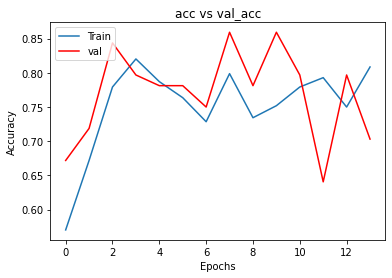

In [ ]:
plt.plot(his['accuracy'])
plt.plot(his['val_accuracy'], c ='red')

plt.title('acc vs val_acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")
plt.show

<function matplotlib.pyplot.show>

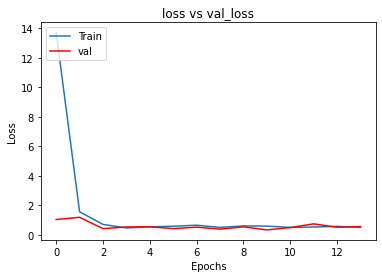

In [ ]:
plt.plot(his['loss'])
plt.plot(his['val_loss'], c ='red')

plt.title('loss vs val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show

In [ ]:
#model accuracy

from keras.models import load_model

model = load_model('/content/bestmodel.h5')

In [ ]:
acc = model.evaluate_generator(test_data)[1]

print(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


0.804809033870697
